In [54]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import seaborn as sns

In [55]:
with open("gruid-translator/out/out__1-0.json") as f:
    data = json.load(f)

In [56]:
print(data.keys())

dict_keys(['output.txt event 1', 'output.txt event 2', 'output.txt event 3', 'output.txt event 4', 'output.txt event 5'])


In [57]:
for event in data:
    metadata = data[event]['gruid metadata']
    print(f"Event: {event}")
    print(f"Number of columns: {metadata['# of columns (x)']}")
    print(f"Number of rows: {metadata['# of rows (y)']}")
    print(f"Time interval: {metadata['dt']}")
    print(f"X interval: {metadata['dx']}")
    print(f"Y interval: {metadata['dy']}")
    print(f"PID: {metadata['pid']}\n")

Event: output.txt event 1
Number of columns: 7
Number of rows: 10
Time interval: 30.0
X interval: 0.1
Y interval: 0.1
PID: -13

Event: output.txt event 2
Number of columns: 7
Number of rows: 10
Time interval: 30.0
X interval: 0.1
Y interval: 0.1
PID: -13

Event: output.txt event 3
Number of columns: 7
Number of rows: 10
Time interval: 30.0
X interval: 0.1
Y interval: 0.1
PID: -13

Event: output.txt event 4
Number of columns: 7
Number of rows: 10
Time interval: 30.0
X interval: 0.1
Y interval: 0.1
PID: -13

Event: output.txt event 5
Number of columns: 7
Number of rows: 10
Time interval: 30.0
X interval: 0.1
Y interval: 0.1
PID: -13



In [58]:

results = []
for event, event_data in data.items():
    gruid_hits_side_1 = event_data['gruid hits - side 1']
    gruid_hits_side_2 = event_data['gruid hits - side 2']
    gruid_metadata = event_data['gruid metadata']
    run, event_n = event.split("event")
    
    for channel, channel_data in gruid_hits_side_1.items():
        for pixel, pixel_data in channel_data.items():
            results.append({
                'run': run,
                'event': int(event_n),
                'channel': channel,
                'x': pixel[0],
                'y': pixel[2],
                'side': 1,
                'num_hits': pixel_data['# of hits'],
                'energy_deposited': pixel_data['energy deposited'],
                'particle_id': gruid_metadata['pid']
            })
            
    for channel, channel_data in gruid_hits_side_2.items():
        for pixel, pixel_data in channel_data.items():
            results.append({
                'run': run,
                'event': int(event_n),
                'channel': channel,
                'x': pixel[0],
                'y': pixel[2],
                'side': 2,
                'num_hits': pixel_data['# of hits'],
                'energy_deposited': pixel_data['energy deposited'],
                'particle_id': gruid_metadata['pid']
            })
            
df = pd.DataFrame(results)


In [59]:
df

,run,event,channel,x,y,side,num_hits,energy_deposited,particle_id
0,output.txt,1,0.0,3,0,1,3,1.055848e-05,-13
1,output.txt,1,0.0,3,1,1,4,1.983216e-05,-13
2,output.txt,1,0.0,3,3,1,2,1.704438e-05,-13
3,output.txt,1,0.0,3,4,1,1,4.978063e-06,-13
4,output.txt,1,0.0,4,0,1,1,4.003723e-07,-13
5,output.txt,1,0.0,4,1,1,2,1.348137e-05,-13
6,output.txt,1,0.0,4,3,1,5,2.023188e-05,-13
7,output.txt,1,0.0,4,4,1,1,5.154319e-06,-13
8,output.txt,1,0.0,4,6,1,1,4.515259e-06,-13
9,output.txt,1,0.0,4,7,1,1,5.892595e-06,-13


In [60]:
# Check the dimensions of the dataframe
print(df.shape)
print("")
# Get summary statistics for numeric columns
print(df.describe())
print("")
# Check the data types of each column and the number of non-null values
print(df.info())
print("")

(53, 9)

           event       side   num_hits  energy_deposited  particle_id
count  53.000000  53.000000  53.000000      5.300000e+01         53.0
mean    2.698113   1.566038   3.037736      1.683148e-05        -13.0
std     1.501088   0.500363   2.961044      1.521223e-05          0.0
min     1.000000   1.000000   1.000000      4.003723e-07        -13.0
25%     1.000000   1.000000   1.000000      5.154319e-06        -13.0
50%     3.000000   2.000000   2.000000      1.055848e-05        -13.0
75%     4.000000   2.000000   4.000000      2.245292e-05        -13.0
max     5.000000   2.000000  15.000000      6.848401e-05        -13.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   run               53 non-null     object 
 1   event             53 non-null     int64  
 2   channel           53 non-null     object 
 3   x                 

<Axes: ylabel='Density'>

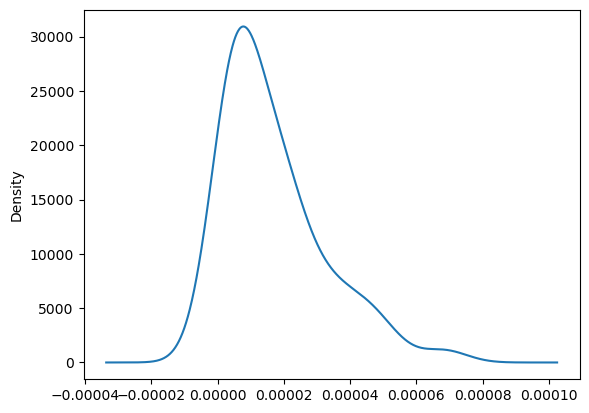

In [61]:
# Create histograms or density plots to visualize the distribution of numeric columns
#df['num_hits'].hist()
df['energy_deposited'].plot.density()

In [62]:
# create separate dataframes for each event and side
df_e1s1 = df[(df['event'] == 1) & (df['side'] == 1)]
df_e1s2 = df[(df['event'] == 1) & (df['side'] == 2)]
df_e2s1 = df[(df['event'] == 2) & (df['side'] == 1)]
df_e2s2 = df[(df['event'] == 2) & (df['side'] == 2)]

In [63]:
df_e1s1

,run,event,channel,x,y,side,num_hits,energy_deposited,particle_id
0,output.txt,1,0.0,3,0,1,3,1.055848e-05,-13
1,output.txt,1,0.0,3,1,1,4,1.983216e-05,-13
2,output.txt,1,0.0,3,3,1,2,1.704438e-05,-13
3,output.txt,1,0.0,3,4,1,1,4.978063e-06,-13
4,output.txt,1,0.0,4,0,1,1,4.003723e-07,-13
5,output.txt,1,0.0,4,1,1,2,1.348137e-05,-13
6,output.txt,1,0.0,4,3,1,5,2.023188e-05,-13
7,output.txt,1,0.0,4,4,1,1,5.154319e-06,-13
8,output.txt,1,0.0,4,6,1,1,4.515259e-06,-13
9,output.txt,1,0.0,4,7,1,1,5.892595e-06,-13


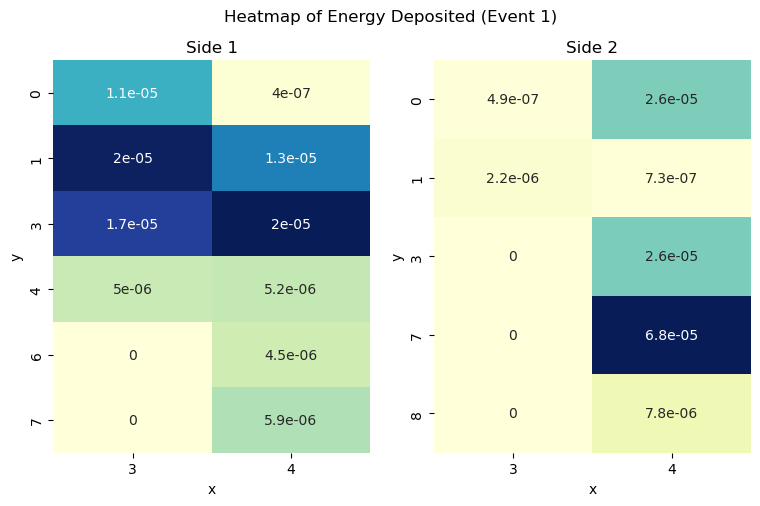

In [64]:
heatmap_e1s1 = pd.pivot_table(df_e1s1, values="energy_deposited", index="y", columns="x", fill_value=0)
heatmap_e1s2 = pd.pivot_table(df_e1s2, values="energy_deposited", index="y", columns="x", fill_value=0)

fig, axs = plt.subplots(ncols=2)
fig.suptitle('Heatmap of Energy Deposited (Event 1)')

sns.heatmap(heatmap_e1s1, ax=axs[0], cmap="YlGnBu", annot=True, cbar=False)
fig.set_size_inches(9, 5.1)
tile = axs[0].set_title("Side 1")
tile.set_position([.5, 1.05])

sns.heatmap(heatmap_e1s2, ax=axs[1], cmap="YlGnBu", annot=True, cbar=False)
fig.set_size_inches(9, 5.1)
tile = axs[1].set_title("Side 2")
tile.set_position([.5, 1.05])


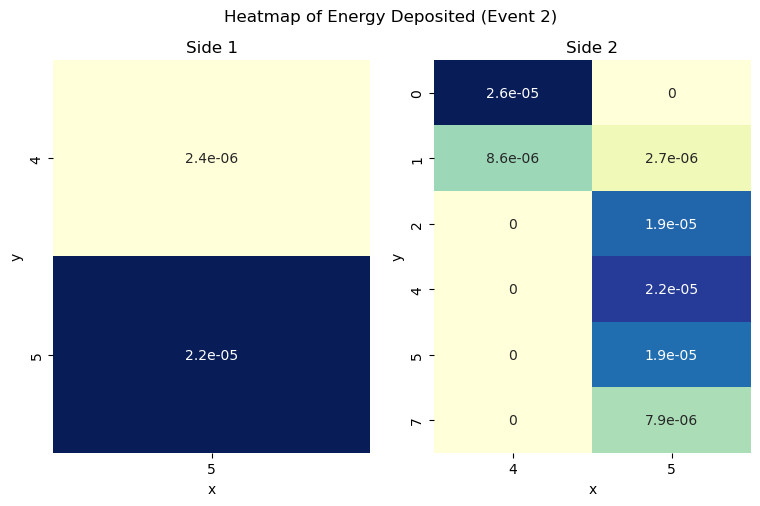

In [65]:
heatmap_e2s1 = pd.pivot_table(df_e2s1, values="energy_deposited", index="y", columns="x", fill_value=0)
heatmap_e2s2 = pd.pivot_table(df_e2s2, values="energy_deposited", index="y", columns="x", fill_value=0)

fig, axs = plt.subplots(ncols=2)
fig.suptitle('Heatmap of Energy Deposited (Event 2)')

sns.heatmap(heatmap_e2s1, ax=axs[0], cmap="YlGnBu", annot=True, cbar=False)
fig.set_size_inches(9, 5.1)
tile = axs[0].set_title("Side 1")
tile.set_position([.5, 1.05])

sns.heatmap(heatmap_e2s2, ax=axs[1], cmap="YlGnBu", annot=True, cbar=False)
fig.set_size_inches(9, 5.1)
tile = axs[1].set_title("Side 2")
tile.set_position([.5, 1.05])


In [66]:
#heatmap_e1s1 = pd.pivot_table(df_e1s1, values="energy_deposited", index="y", columns="x", fill_value=0)
#sns.heatmap(heatmap_e1s1, cmap="YlGnBu", annot=True)
#plt.title('Heatmap of Energy Deposited (Event 1) - Side 1')
#plt.show()

#heatmap_e1s2 = pd.pivot_table(df_e1s2, values="energy_deposited", index="y", columns="x", fill_value=0)
#sns.heatmap(heatmap_e1s2, cmap="YlGnBu", annot=True)
#plt.title('Heatmap of Energy Deposited (Event 1) - Side 2')

#heatmap_e2s1 = pd.pivot_table(df_e2s1, values="energy_deposited", index="y", columns="x", fill_value=0)
#sns.heatmap(heatmap_e2s1, cmap="YlGnBu", annot=True)
#plt.title('Heatmap of Energy Deposited (Event 2) - Side 1')

#heatmap_e2s2 = pd.pivot_table(df_e2s2, values="energy_deposited", index="y", columns="x", fill_value=0)
#sns.heatmap(heatmap_e2s2, cmap="YlGnBu", annot=True)
#plt.title('Heatmap of Energy Deposited (Event 2) - Side 2')

In [67]:
# Transform pivot table into a numpy array
matrix_e1s1 = heatmap_e1s1.to_numpy()
matrix_e1s2 = heatmap_e1s2.to_numpy()
matrix_e2s1 = heatmap_e2s1.to_numpy()
matrix_e2s2 = heatmap_e2s2.to_numpy()

In [84]:
# Print the numpy arrays in a more readable format with high precision and with scientific notation
np.set_printoptions(precision=5, suppress=False)
print(matrix_e1s1)
print("")
print(matrix_e1s2)
print("")
print(matrix_e2s1)
print("")
print(matrix_e2s2)


[[1.05585e-05 4.00372e-07]
 [1.98322e-05 1.34814e-05]
 [1.70444e-05 2.02319e-05]
 [4.97806e-06 5.15432e-06]
 [0.00000e+00 4.51526e-06]
 [0.00000e+00 5.89259e-06]]

[[4.91028e-07 2.57451e-05]
 [2.21679e-06 7.27175e-07]
 [0.00000e+00 2.60582e-05]
 [0.00000e+00 6.84840e-05]
 [0.00000e+00 7.77505e-06]]

[[2.44484e-06]
 [2.22461e-05]]

[[2.63286e-05 0.00000e+00]
 [8.58213e-06 2.69036e-06]
 [0.00000e+00 1.92749e-05]
 [0.00000e+00 2.24529e-05]
 [0.00000e+00 1.86784e-05]
 [0.00000e+00 7.88103e-06]]


In [33]:
#IDEA

'''
data = open("gruid-translator/out/out__1-0.json", "r").read()

# Initialize empty lists to store the data
means_side1 = []
stds_side1 = []
means_side2 = []
stds_side2 = []

# Loop through each event and calculate the mean and standard deviation of energy deposited
for event in data:
    # Side 1
    energy_side1 = []
    for k, v in data[int(event)]["gruid hits - side 1"]["0.0"].items():
        energy_side1.extend([hit["energy deposited"] for hit in v.values()])
    means_side1.append(np.mean(energy_side1))
    stds_side1.append(np.std(energy_side1))
    
    # Side 2
    energy_side2 = []
    for k, v in data[int(event)]["gruid hits - side 2"]["0.0"].items():
        energy_side2.extend([hit["energy deposited"] for hit in v.values()])
    means_side2.append(np.mean(energy_side2))
    stds_side2.append(np.std(energy_side2))

# Plot the results
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].bar(range(len(data)), means_side1, yerr=stds_side1)
axs[0, 0].set_xticks(range(len(data)))
axs[0, 0].set_xticklabels(list(data.keys()))
axs[0, 0].set_ylabel("Mean energy deposited (Side 1)")
axs[0, 1].bar(range(len(data)), means_side2, yerr=stds_side2)
axs[0, 1].set_xticks(range(len(data)))
axs[0, 1].set_xticklabels(list(data.keys()))
axs[0, 1].set_ylabel("Mean energy deposited (Side 2)")
axs[1, 0].hist(energy_side1, bins=20)
axs[1, 0].set_xlabel("Energy deposited (Side 1)")
axs[1, 0].set_ylabel("Frequency")
axs[1, 1].hist(energy_side2, bins=20)
axs[1, 1].set_xlabel("Energy deposited (Side 2)")
axs[1, 1].set_ylabel("Frequency")
plt.tight_layout()
plt.show()

# IDEA 
for event in data:
    total_hits = 0
    total_energy = 0
    for side in data[event]:
        for pos in data[event][side]:
            print(pos)
            for hits in data[event][side][pos]:
                total_hits += data[event][side][pos][hits]['# of hits']
                total_energy += data[event][side][pos][hits]['energy deposited']
    print(f"Event: {event}")
    print(f"Total number of hits: {total_hits}")
    print(f"Total energy deposited: {total_energy}\n")
'''

'\ndata = open("gruid-translator/out/out__1-0.json", "r").read()\n\n# Initialize empty lists to store the data\nmeans_side1 = []\nstds_side1 = []\nmeans_side2 = []\nstds_side2 = []\n\n# Loop through each event and calculate the mean and standard deviation of energy deposited\nfor event in data:\n    # Side 1\n    energy_side1 = []\n    for k, v in data[int(event)]["gruid hits - side 1"]["0.0"].items():\n        energy_side1.extend([hit["energy deposited"] for hit in v.values()])\n    means_side1.append(np.mean(energy_side1))\n    stds_side1.append(np.std(energy_side1))\n    \n    # Side 2\n    energy_side2 = []\n    for k, v in data[int(event)]["gruid hits - side 2"]["0.0"].items():\n        energy_side2.extend([hit["energy deposited"] for hit in v.values()])\n    means_side2.append(np.mean(energy_side2))\n    stds_side2.append(np.std(energy_side2))\n\n# Plot the results\nfig, axs = plt.subplots(2, 2, figsize=(10, 8))\naxs[0, 0].bar(range(len(data)), means_side1, yerr=stds_side1)\naxs[